In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys
parent_path = str(Path().joinpath('..\..').resolve())
sys.path.append(parent_path)

In [3]:
from triple_agent.parsing.replay.get_parsed_replays import get_parsed_replays
from triple_agent.constants.events import select_sc19
from triple_agent.reports.specific.character_selection import (spy_selection,
                                                      st_selection,
                                                      amba_selection,
                                                      double_agent_selection,
                                                      determine_character_in_role)
from triple_agent.reports.specific.game_outcomes import game_outcomes
from triple_agent.classes.roles import Roles
from triple_agent.classes.outcomes import WinType
from triple_agent.classes.missions import Missions, MissionStatus
from triple_agent.reports.generation.common_sort_functions import sort_by_spy_wins, sort_by_sniper_wins
from triple_agent.reports.generation.plot_specs import AxisProperties, DataQueryProperties, PlotLabelStyle
from triple_agent.reports.specific.action_tests import action_test_percentages, diff_action_test_percentages
from triple_agent.reports.specific.mission_choices import mission_choices
from triple_agent.reports.specific.mission_completes import (mission_completion_query,
    mission_completion,
    _mission_completes_details)
from triple_agent.classes.action_tests import ActionTest
from collections import Counter, defaultdict

In [4]:
replays = get_parsed_replays(lambda g: g.event == 'Winter Cup 2020')

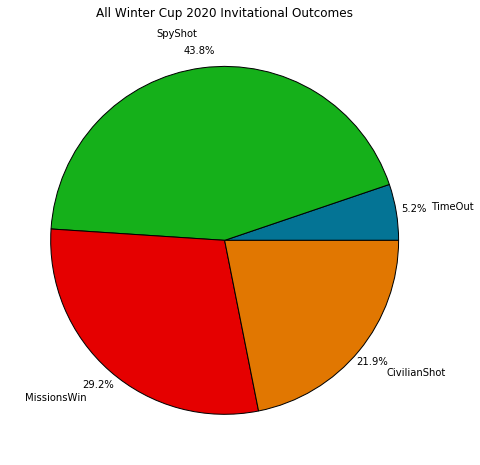

,WinType.TimeOut,WinType.SpyShot,WinType.MissionsWin,WinType.CivilianShot
NaN,5,42,28,21


In [5]:
game_outcomes(
    replays,
    axis_properties=AxisProperties(title="All Winter Cup 2020 Invitational Outcomes")
).frame

### Included Games

In [6]:
Counter((r.division, tuple(sorted([r.spy, r.sniper]))) for r in replays)

Counter({('Vixen', ('Corvusmellori', 'pipesuper24')): 12,
         ('Prancer', ('iggythegrifter', 'lauras43')): 12,
         ('Dancer', ('Collateral Damage', 'lazybear')): 12,
         ('Prancer', ('lauras43', 'spedmonkey')): 12,
         ('Vixen', ('humankirby', 'turnipboy')): 12,
         ('Vixen', ('beanie', 'turnipboy')): 12,
         ('Dasher', ('Beanie', 'KumaKid')): 12,
         ('Cupid', ('Max Edward Snax', 'dbdkmezz')): 12})

## Most Picked / Banned

In [7]:
BigBois = "The Big Bois"
EyeInSky = "Eye in the Sky"
CouldYouSee = "Could you see that?"

In [8]:
map_groups = {
    BigBois: {'Terrace','Gallery','Veranda','Library'},
    EyeInSky: {'Balcony','Pub','Courtyard','Moderne'},
    CouldYouSee: {'High-Rise','Ballroom','Aquarium','Teien'},
}

In [9]:
from itertools import zip_longest

def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

In [10]:
def identify_groups(played_venues):
    picked_groups = set()
    bans = set()
    for venue in played_venues:
        for group in [BigBois, EyeInSky, CouldYouSee]:
            if venue in map_groups[group]:
                picked_groups.add(group)
        if len(picked_groups) == 2:
            break
            
    for group in picked_groups:
        for venue in map_groups[group]:
            bans.add(venue)
            
    for venue in played_venues:
        bans.discard(venue)
        
    return picked_groups, bans

In [11]:
sorted_replays = sorted(replays, key=lambda g: (g.division, sorted([g.spy, g.sniper]), g.start_time))

In [12]:
all_group_picks = Counter()
all_bans = Counter()

for g in grouper(sorted_replays, 12):
    groups, bans = identify_groups([r.venue for r in g])
    all_group_picks.update(Counter(groups))
    all_bans.update(Counter(bans))
    
all_group_picks, all_bans

(Counter({'The Big Bois': 6, 'Could you see that?': 5, 'Eye in the Sky': 5}),
 Counter({'Terrace': 2,
          'Teien': 4,
          'High-Rise': 1,
          'Courtyard': 1,
          'Balcony': 2,
          'Gallery': 2,
          'Moderne': 2,
          'Veranda': 1,
          'Library': 1}))

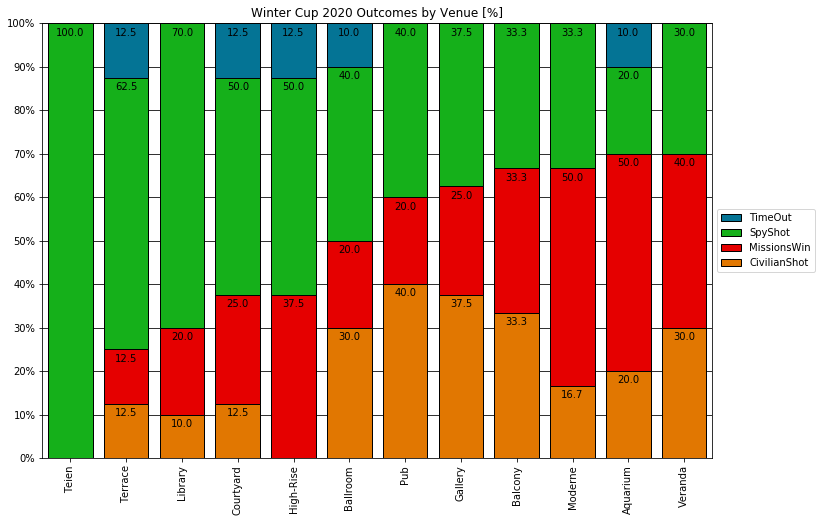

,Teien,Terrace,Library,Courtyard,High-Rise,Ballroom,Pub,Gallery,Balcony,Moderne,Aquarium,Veranda
WinType.TimeOut,0.0,0.125,0.0,0.125,0.125,0.1,0.0,0.000,0.000000,0.000000,0.1,0.0
WinType.SpyShot,1.0,0.625,0.7,0.500,0.500,0.4,0.4,0.375,0.333333,0.333333,0.2,0.3
WinType.MissionsWin,0.0,0.125,0.2,0.250,0.375,0.2,0.2,0.250,0.333333,0.500000,0.5,0.4
WinType.CivilianShot,0.0,0.125,0.1,0.125,0.000,0.3,0.4,0.375,0.333333,0.166667,0.2,0.3


In [13]:
game_outcomes(
    replays,
    DataQueryProperties(
        groupby=lambda g: g.venue,
        secondary_order=sort_by_spy_wins,
        percent_normalized_data=True,
    ),
    axis_properties=AxisProperties(
        title="Winter Cup 2020 Outcomes by Venue [%]",
        data_label_style=PlotLabelStyle.Plain,
    )
).frame

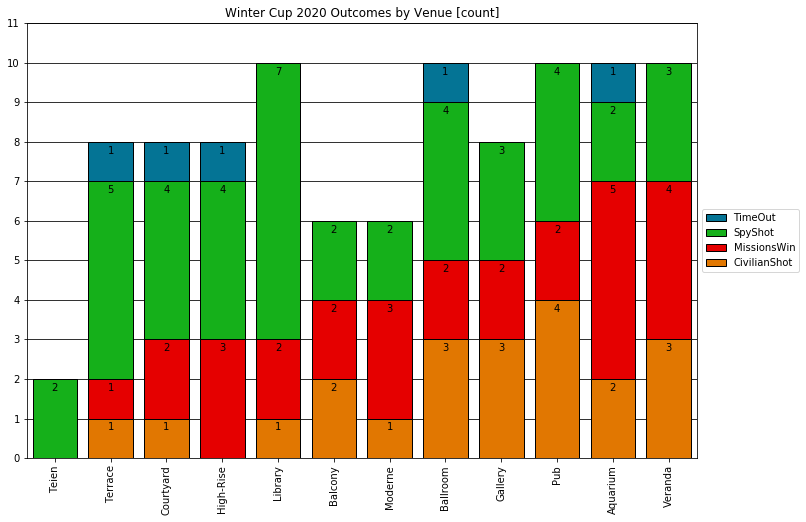

,Teien,Terrace,Courtyard,High-Rise,Library,Balcony,Moderne,Ballroom,Gallery,Pub,Aquarium,Veranda
WinType.TimeOut,0,1,1,1,0,0,0,1,0,0,1,0
WinType.SpyShot,2,5,4,4,7,2,2,4,3,4,2,3
WinType.MissionsWin,0,1,2,3,2,2,3,2,2,2,5,4
WinType.CivilianShot,0,1,1,0,1,2,1,3,3,4,2,3


In [14]:
game_outcomes(
    replays,
    DataQueryProperties(
        groupby=lambda g: g.venue,
        secondary_order=sort_by_spy_wins,
    ),
    axis_properties=AxisProperties(
        title="Winter Cup 2020 Outcomes by Venue [count]",
        data_label_style=PlotLabelStyle.Plain,
    )
).frame

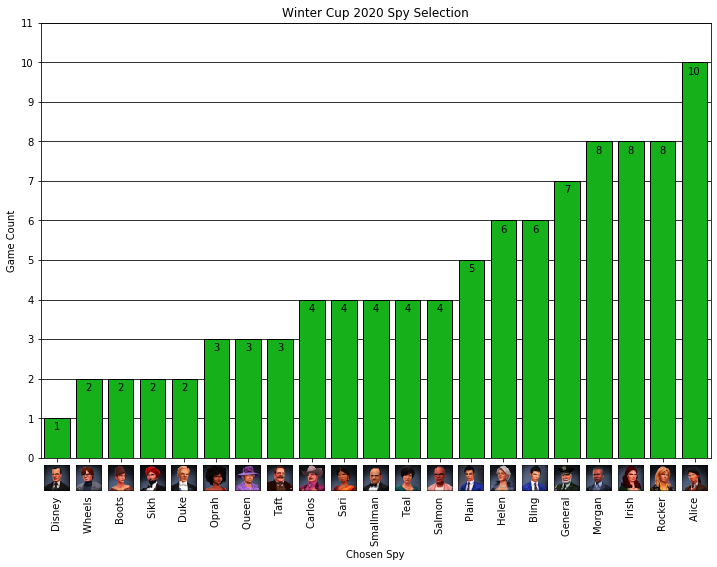

In [15]:
_ = spy_selection(
    replays,
    axis_properties = AxisProperties(
        title="Winter Cup 2020 Spy Selection",
        x_axis_portrait=True,
        y_axis_label="Game Count",
        x_axis_label="Chosen Spy",
    ),
    data_query = DataQueryProperties(
        primary_order=sum,
    )
)

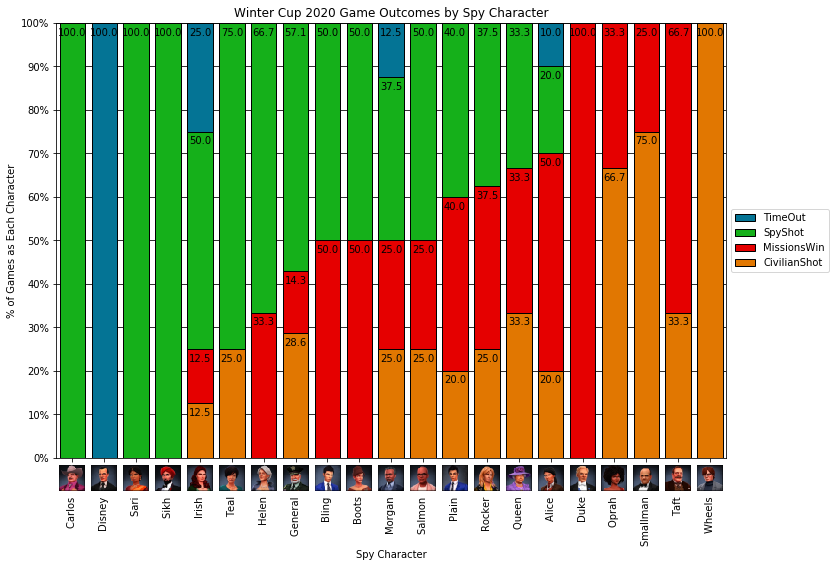

In [16]:
_ = game_outcomes(
    replays,
    axis_properties = AxisProperties(
        title="Winter Cup 2020 Game Outcomes by Spy Character",
        x_axis_portrait=True,
        y_axis_label="% of Games as Each Character",
        x_axis_label="Spy Character",
        data_label_style=PlotLabelStyle.Plain,
    ),
    data_query = DataQueryProperties(
        groupby=lambda g: determine_character_in_role(g, Roles.Spy),
        secondary_order=sort_by_spy_wins,
        percent_normalized_data=True
    )
)

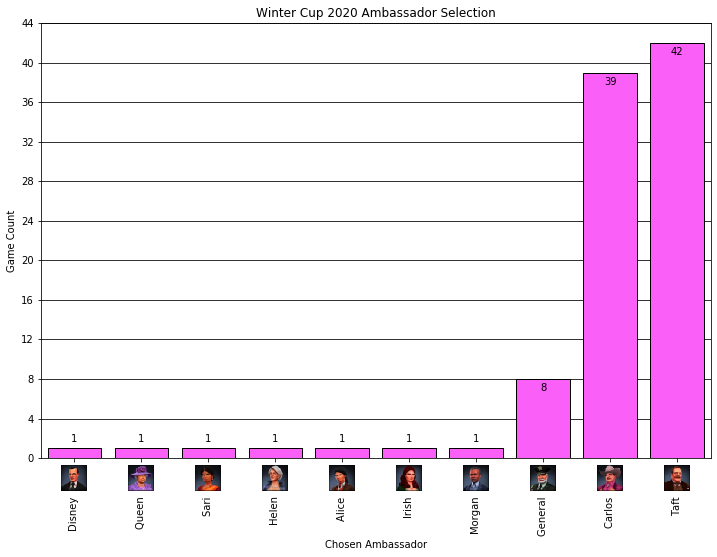

In [17]:
_ = amba_selection(
    replays,
    axis_properties = AxisProperties(
        title="Winter Cup 2020 Ambassador Selection",
        x_axis_portrait=True,
        y_axis_label="Game Count",
        x_axis_label="Chosen Ambassador",
    ),
    data_query = DataQueryProperties(
        primary_order=sum,
    )
)

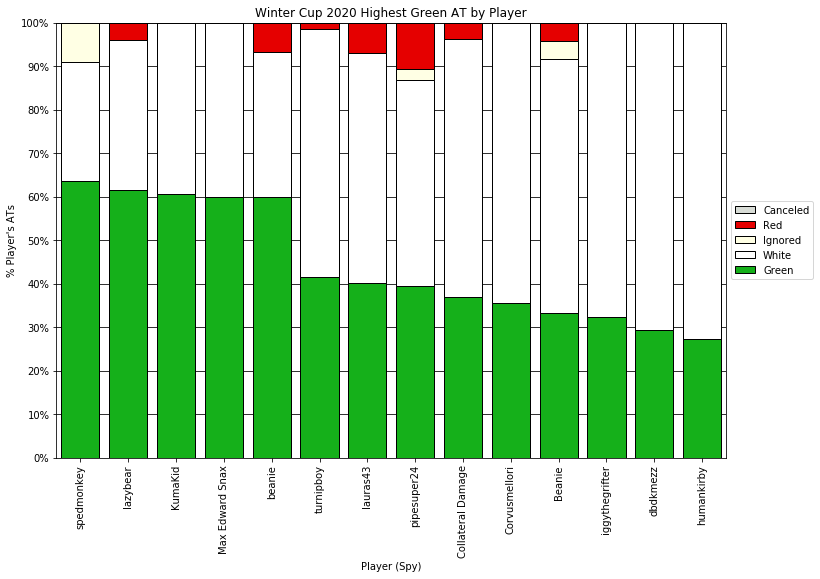

In [18]:
_ = action_test_percentages(
    replays,
    axis_properties = AxisProperties(
        title='Winter Cup 2020 Highest Green AT by Player',
        x_axis_label='Player (Spy)',
        y_axis_label='% Player\'s ATs',
    ),
    data_query = DataQueryProperties(
        groupby=lambda g: g.spy,
        secondary_order=lambda name_series: -name_series[1][ActionTest.Green],
        limit=30,
        reverse_primary_order=True,
        percent_normalized_data=True)    
)

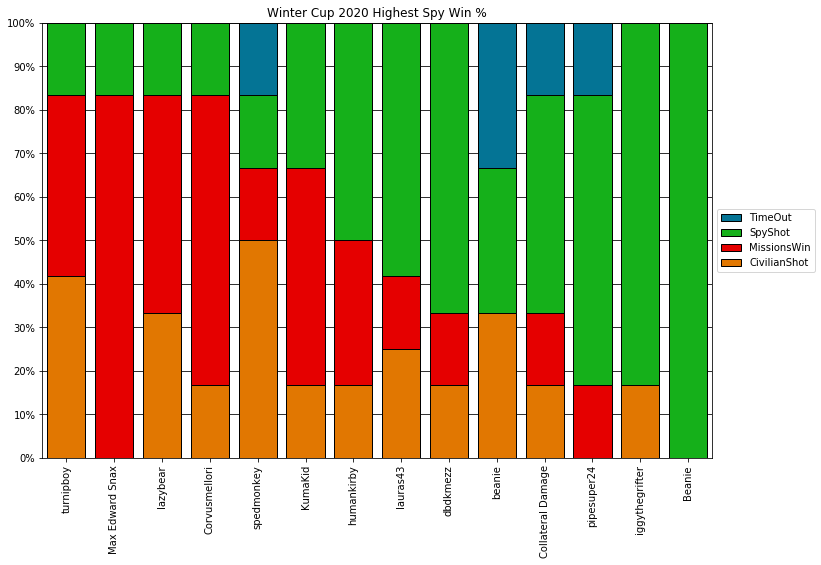

In [19]:
spy_winr = game_outcomes(
    replays,
    DataQueryProperties(
        groupby=lambda g: g.spy,
        secondary_order=sort_by_spy_wins,
        reverse_secondary_order=True,
        limit=30,
        percent_normalized_data=True),
    axis_properties=AxisProperties(title="Winter Cup 2020 Highest Spy Win %")
)

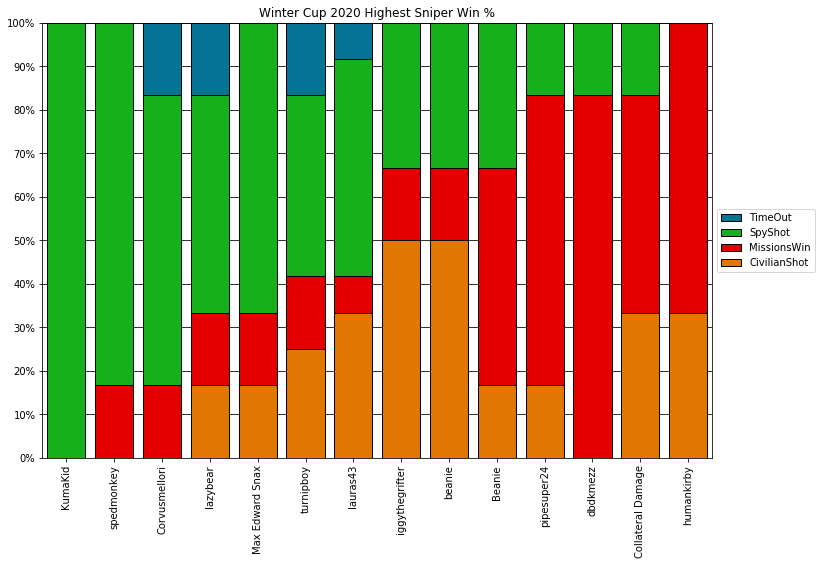

In [20]:
_ = game_outcomes(
    replays,
    DataQueryProperties(
        groupby=lambda g: g.sniper,
        secondary_order=sort_by_sniper_wins,
        reverse_secondary_order=True,
        limit=30,
        percent_normalized_data=True),
    axis_properties=AxisProperties(title="Winter Cup 2020 Highest Sniper Win %")
)

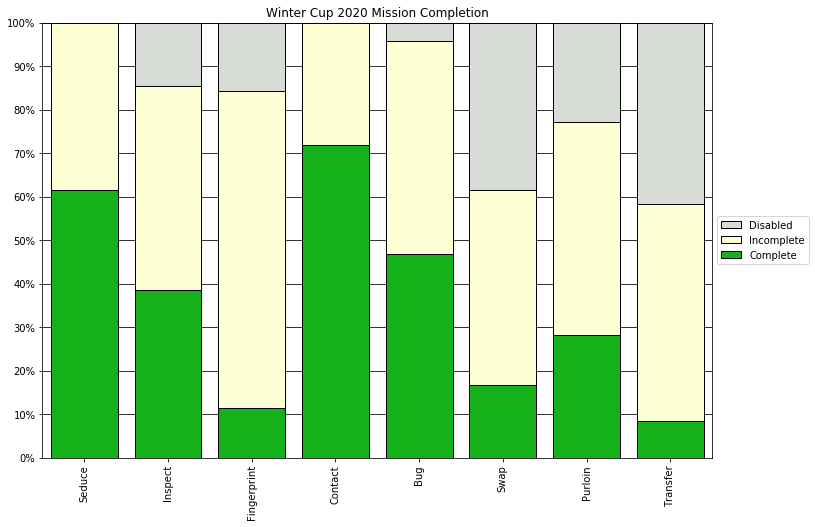

In [21]:
mission_completion(replays, "Winter Cup 2020 Mission Completion")